In [5]:
import yfinance as yf
import pandas as pd
import os

In [6]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0, parse_dates=True)
    sp500.index = pd.to_datetime(sp500.index, utc=True)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [7]:
sp500.index = pd.to_datetime(sp500.index)

In [8]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-10 04:00:00+00:00,5341.220215,5365.790039,5331.520020,5360.790039,3622280000,0.0,0.0
2024-06-11 04:00:00+00:00,5353.000000,5375.950195,5327.250000,5375.319824,3568030000,0.0,0.0
2024-06-12 04:00:00+00:00,5409.129883,5447.250000,5409.129883,5421.029785,3962840000,0.0,0.0


<Axes: xlabel='Date'>

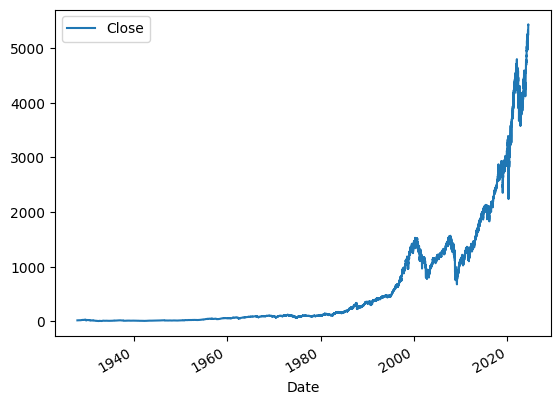

In [9]:
sp500.plot.line(y="Close", use_index=True)

In [10]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [11]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [12]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [13]:
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [15]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.75

<Axes: xlabel='Date'>

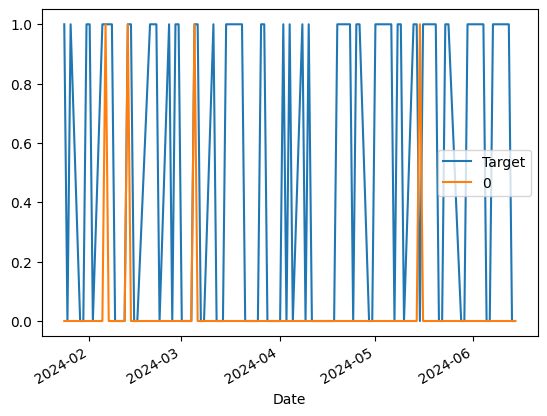

In [16]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [33]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [34]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [35]:
predictions = backtest(sp500, model, predictors)

In [36]:
predictions["Predictions"].value_counts()


Predictions
0    2929
1    2251
Name: count, dtype: int64

In [37]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5388716126166149

In [38]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544595
0    0.455405
Name: count, dtype: float64

In [39]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [40]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [41]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1997-11-26 05:00:00+00:00,950.820007,956.469971,950.820007,951.640015,487750000,955.400024,1,1.000431,2.0,0.997275,4.0,1.009111,33.0,1.113282,138.0,1.517046,563.0
1997-11-28 05:00:00+00:00,951.640015,959.130005,951.640015,955.400024,189070000,974.770020,1,1.001972,2.0,1.001967,4.0,1.012659,33.0,1.116599,139.0,1.521842,564.0
1997-12-01 05:00:00+00:00,955.400024,974.770020,955.400024,974.770020,590300000,971.679993,0,1.010035,2.0,1.019783,4.0,1.032356,34.0,1.138015,140.0,1.551433,564.0
1997-12-02 05:00:00+00:00,974.780029,976.200012,969.830017,971.679993,576120000,976.770020,1,0.998412,1.0,1.011259,4.0,1.028349,33.0,1.133204,140.0,1.545272,563.0
1997-12-03 05:00:00+00:00,971.679993,980.809998,966.159973,976.770020,624610000,973.099976,0,1.002612,1.0,1.011095,4.0,1.032949,33.0,1.137882,141.0,1.552105,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10 04:00:00+00:00,5341.220215,5365.790039,5331.520020,5360.790039,3622280000,5375.319824,1,1.001289,1.0,1.003664,3.0,1.031883,33.0,1.132566,139.0,1.274758,530.0
2024-06-11 04:00:00+00:00,5353.000000,5375.950195,5327.250000,5375.319824,3568030000,5421.029785,1,1.001353,2.0,1.003229,3.0,1.033823,34.0,1.134670,139.0,1.277522,531.0
2024-06-12 04:00:00+00:00,5409.129883,5447.250000,5409.129883,5421.029785,3962840000,5433.740234,1,1.004234,2.0,1.009236,3.0,1.041707,34.0,1.143307,139.0,1.287680,531.0


In [42]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [43]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [46]:
predictions = backtest(sp500, model, new_predictors)

In [47]:
predictions["Predictions"].value_counts()

Predictions
0.0    3615
1.0     565
Name: count, dtype: int64

In [48]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5628318584070796

In [49]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.541148
0    0.458852
Name: count, dtype: float64

In [50]:
predictions

,Target,Predictions
Date,,
2007-11-06 05:00:00+00:00,0,1.0
2007-11-07 05:00:00+00:00,0,1.0
2007-11-08 05:00:00+00:00,0,1.0
2007-11-09 05:00:00+00:00,0,1.0
2007-11-12 05:00:00+00:00,1,1.0
...,...,...
2024-06-10 04:00:00+00:00,1,0.0
2024-06-11 04:00:00+00:00,1,0.0
2024-06-12 04:00:00+00:00,1,0.0
